In [2]:
# Preparamos el entorno de trabajo para todo el flujo.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


from pathlib import Path
from IPython.display import display, Markdown
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Configuración global para reproducibilidad y estilo de gráficos
RANDOM_STATE = 42
RESULTS_DIR = Path('../Results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

In [3]:
# Comprensión del dataset
df = pd.read_excel('/content/citaschallenge.xlsx')

print(df.head())
print(df.info())
print(df.describe(include='all'))

     GENERO  EDAD         ESPECIALIDAD TIPO_AFILIACION          FECHA_CITA  \
0  FEMENINO  41.0           ORTODONCIA            GOLD 2013-07-02 06:30:00   
1  FEMENINO  49.0  TERAPIA OCUPACIONAL          SILVER 2013-07-02 06:30:00   
2  FEMENINO  41.0         FISIOTERAPIA            GOLD 2013-07-02 06:30:00   
3  FEMENINO  49.0         FISIOTERAPIA            GOLD 2013-07-02 06:50:00   
4  FEMENINO  36.0           RADIOLOGIA            GOLD 2013-07-02 06:50:00   

      id  ESTAFINAL  
0   9373          3  
1  62884          2  
2  72568          2  
3   5733          1  
4  22397          3  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67650 entries, 0 to 67649
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GENERO           67650 non-null  object        
 1   EDAD             67650 non-null  float64       
 2   ESPECIALIDAD     67650 non-null  object        
 3   TIPO_AFILIACION  6765

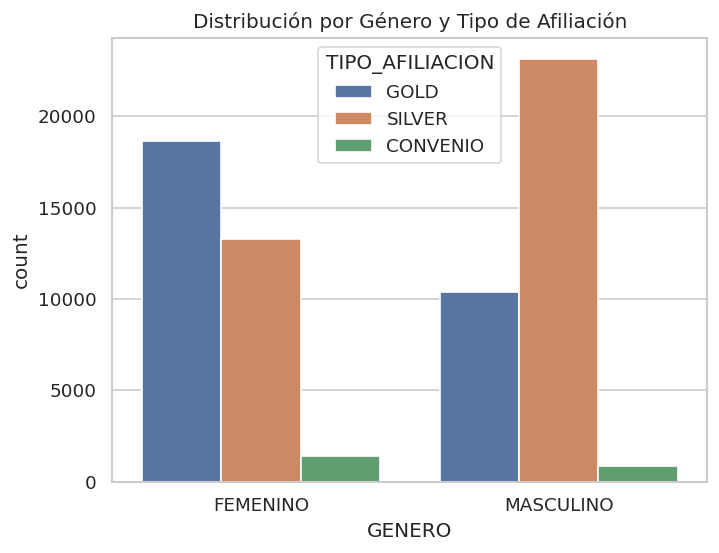

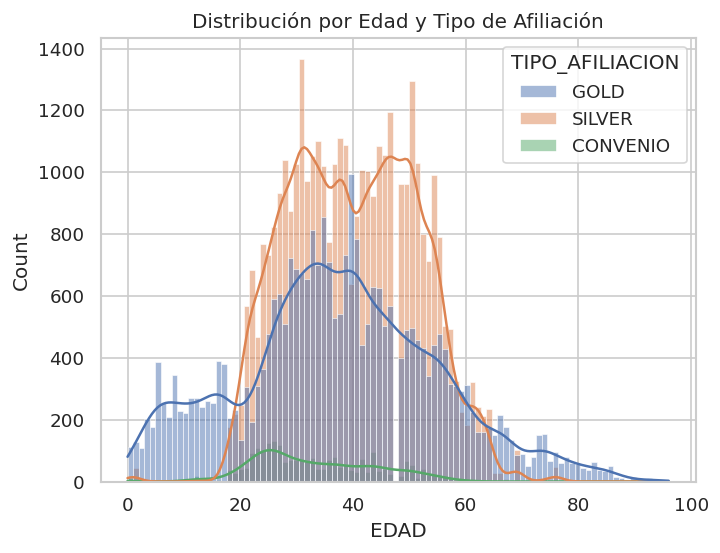

GENERO
FEMENINO     55.924213
MASCULINO    30.166540
dtype: float64


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Import pandas as df will be loaded here

# Load the dataframe (from cell qy-dO8Tsvl0L) to resolve NameError for 'df'
df = pd.read_excel('/content/citaschallenge.xlsx')

# Análisis Exploratorio

#Distribución por Género y Tipo de Afiliación
sns.countplot(data=df, x='GENERO', hue='TIPO_AFILIACION')
plt.title('Distribución por Género y Tipo de Afiliación')
plt.show()

# Distribución por Edad y Tipo de Afiliiación
sns.histplot(data=df, x='EDAD', hue='TIPO_AFILIACION', kde=True)
plt.title('Distribución por Edad y Tipo de Afiliación')
plt.show()

# Tasa de Afiliación Gold por Género
gold_by_gender = df[df['TIPO_AFILIACION'] == 'GOLD'].groupby('GENERO').size()
total_by_gender = df.groupby('GENERO').size()
tasa_gold_by_gender = gold_by_gender / total_by_gender * 100
print(tasa_gold_by_gender)

In [5]:
# Limpieza y preprocesamiento
print('Valores nulos por columna:')
print(df.isnull().sum())


print(f'\nCantidad de filas duplicadas: {df.duplicated().sum()}')

# Definimos mapeos para transformar variables categoricas a numericas.
gender_map = {'FEMENINO': 0, 'MASCULINO': 1}
affiliation_map = {'CONVENIO': 1, 'SILVER': 2, 'GOLD': 3}

df['GENERO'] = df['GENERO'].str.upper().map(gender_map)
df['TIPO_AFILIACION'] = df['TIPO_AFILIACION'].str.upper().map(affiliation_map)

if df['GENERO'].isnull().any():
    faltantes = sorted(df.loc[df['GENERO'].isnull(), 'GENERO'].astype(str).unique())
    raise ValueError(f'Valores inesperados en GENERO tras mapeo: {faltantes}')

if df['TIPO_AFILIACION'].isnull().any():
    faltantes = sorted(df.loc[df['TIPO_AFILIACION'].isnull(), 'TIPO_AFILIACION'].astype(str).unique())
    raise ValueError(f'Valores inesperados en TIPO_AFILIACION tras mapeo: {faltantes}')

df['GENERO'] = df['GENERO'].astype(int)
df['EDAD'] = df['EDAD'].astype(int)
df['TIPO_AFILIACION'] = df['TIPO_AFILIACION'].astype(int)


print('\nTipos de datos luego de limpieza:')
print(df.dtypes)

Valores nulos por columna:
GENERO             0
EDAD               0
ESPECIALIDAD       0
TIPO_AFILIACION    0
FECHA_CITA         0
id                 0
ESTAFINAL          0
dtype: int64

Cantidad de filas duplicadas: 0

Tipos de datos luego de limpieza:
GENERO                      int64
EDAD                        int64
ESPECIALIDAD               object
TIPO_AFILIACION             int64
FECHA_CITA         datetime64[ns]
id                          int64
ESTAFINAL                   int64
dtype: object


In [6]:
# Escalado
X = df[['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Precisión del Modelo: 59.28%


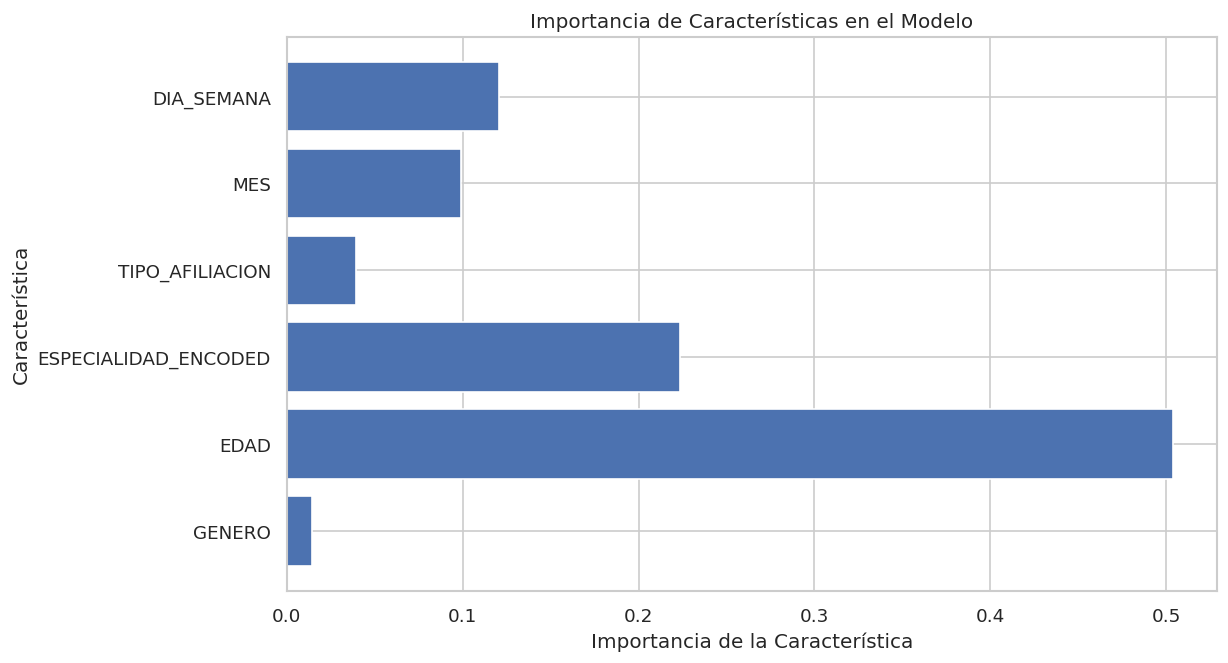

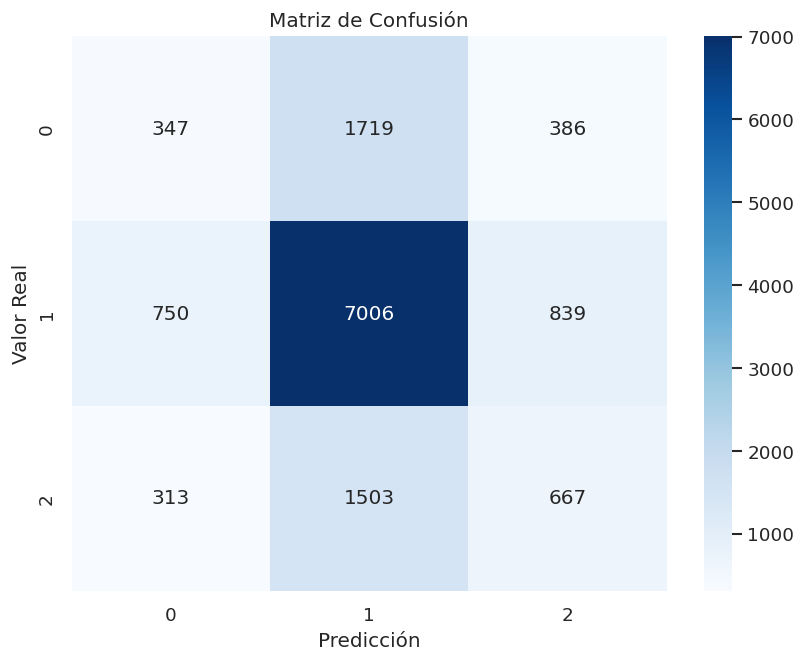

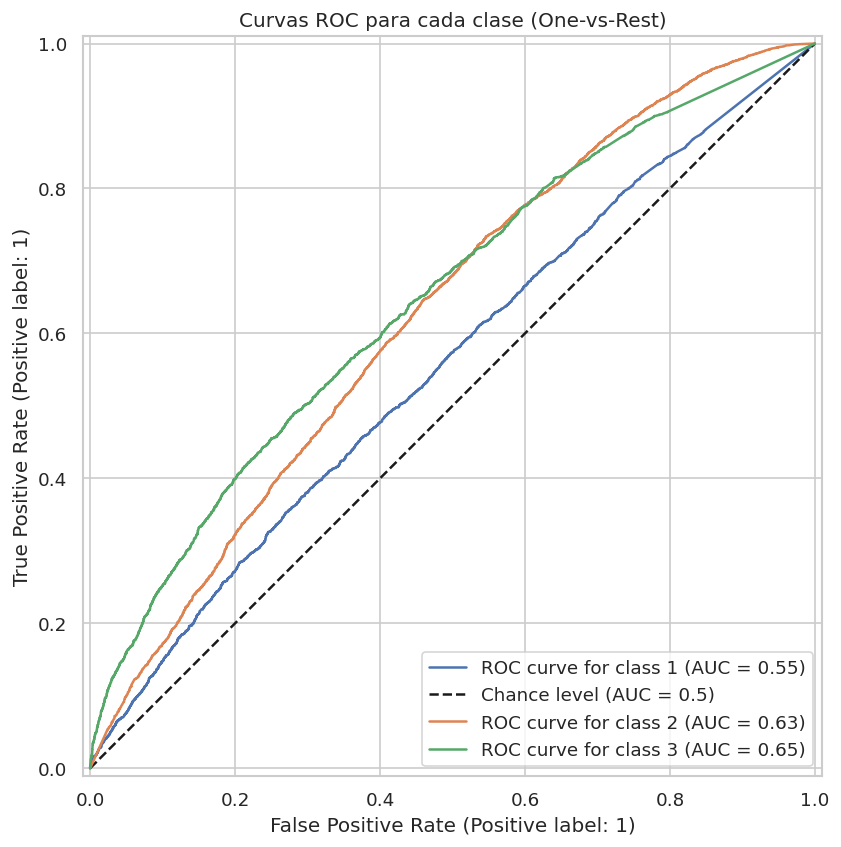

In [14]:
# Implementación de Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Feature Engineering para FECHA_CITA
df['MES'] = df['FECHA_CITA'].dt.month
df['DIA_SEMANA'] = df['FECHA_CITA'].dt.dayofweek

# Codificación de 'ESPECIALIDAD'
df_encondeded = df.copy()
le = LabelEncoder()
df['ESPECIALIDAD_ENCODED'] = le.fit_transform(df['ESPECIALIDAD'])

# Definir características (X) y objetivo (y)
features = ['GENERO', 'EDAD', 'ESPECIALIDAD_ENCODED', 'TIPO_AFILIACION', 'MES', 'DIA_SEMANA']
X = df[features]
y = df['ESTAFINAL']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del Modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluación del Modelo
accuracy = model.score(X_test, y_test)
print(f'Precisión del Modelo: {accuracy * 100:.2f}%')

# Importancia de Características del Modelo
feature_importances = model.feature_importances_
feature_names = features
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Importancia de la Característica')
plt.ylabel('Característica')
plt.title('Importancia de Características en el Modelo')
plt.show()

# Matriz de Confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC y AUC para clasificación multiclase (One-vs-Rest)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

y_pred_proba = model.predict_proba(X_test)

# Get unique classes from y_test and sort them
classes = sorted(y_test.unique())

plt.figure(figsize=(10, 8))
for i, class_id in enumerate(classes):
    # Create a binary target for the current class (one-vs-rest)
    y_test_binary = (y_test == class_id)

    # Plot ROC curve for the current class
    RocCurveDisplay.from_predictions(
        y_test_binary,
        y_pred_proba[:, i], # Probability of the current class
        name=f'ROC curve for class {class_id}',
        ax=plt.gca(),
        plot_chance_level=(i == 0) # Plot chance level only once
    )

plt.title('Curvas ROC para cada clase (One-vs-Rest)')
plt.show()


In [11]:
#Evaluación del Modelo mediante Classification Report
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           1       0.25      0.14      0.18      2452
           2       0.68      0.82      0.74      8595
           3       0.35      0.27      0.30      2483

    accuracy                           0.59     13530
   macro avg       0.43      0.41      0.41     13530
weighted avg       0.54      0.59      0.56     13530



In [1]:
!pip install shap

100%|===================| 60870/60885 [31:56<00:00]       

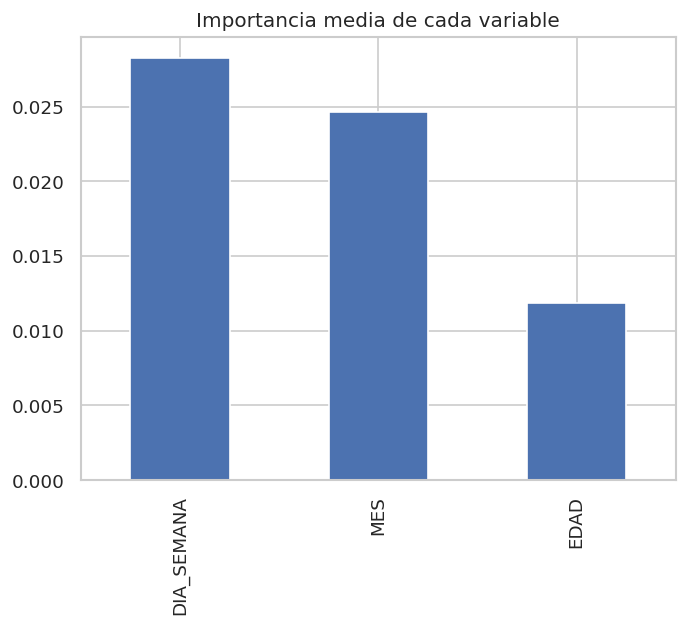

In [18]:
#Implementación SHAP

import shap
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Definición de variable a analizar
features_to_drop_from_X = ['TIPO_AFILIACION', 'GENERO', 'FECHA_CITA', 'id', 'ESPECIALIDAD', 'ESTAFINAL']
X_shap = df.drop(columns=features_to_drop_from_X, errors='ignore')
y_shap = df['TIPO_AFILIACION']

X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(X_shap, y_shap, random_state=43, test_size=0.3)
X_test_df = X_test_shap.copy()

#Entrenar modelo
model_shap = RandomForestClassifier(random_state=42)
model_shap.fit(X_train_shap, y_train_shap)

#Aplicar SHAP usando interfaz universal
explainer = shap.TreeExplainer(model_shap, X_train_shap)
shap_values = explainer(X_test_df)

# Seleccionar solo la clase positiva (índice 1)
# TIPO_AFILIACION, es el objetivo, 3 clases identificadas (CONVENIO:1, SILVER:2, GOLD:3)

# Determinar número de características en SHAP para la clase 1
num_features_in_shap_output = shap_values.values[:, 1, :].shape[1]
shap_values_array = pd.DataFrame(shap_values.values[:, 1, :], columns=shap_values.feature_names[:num_features_in_shap_output])

# Crear DataFrame
shap_df = pd.DataFrame(shap_values_array, columns=shap_values.feature_names[:num_features_in_shap_output])

# Importancia media de cada variable
meas_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

#Visualizar
meas_abs_shap.head(10).plot(kind='bar', title = 'Importancia media de cada variable')
plt.show()

In [19]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=66e7ab80ce4685141210f459c0882ad7a3d4b448728a3bd38c4d326bdd1e4f93
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [20]:
#Implementación LIME
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

#Uso de datos originales con variables catergóricas codificadas
feature_names = X_train.columns.tolist()

#Crear explicador para TIPO_AFILIACION
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=['Convenio', 'Gold', 'Silver'],
    mode='classification',
    discretize_continuous=True
)

#Seleccionar un ejemplo individual a explicar
i = 10  # índice del ejemplo a explicar
exp = explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=model.predict_proba,
    num_features=10
)

#Mostrar Explicaciones
exp.show_in_notebook(show_table=True, show_all=False)


/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.